In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

import cmocean

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

In [3]:
from scipy.constants import c
c

299792458.0

In [42]:
# Angular discretisation

# n = 50
# nn = int(n*n/2)
# ph = linspace(0, 2*pi, n)
# costh = linspace(-1.0, 1.0, int(n/2))
# PH, cosTH = meshgrid(ph,costh)
# X = sin(PH)*cosTH
# Y = sin(PH)*sqrt(1-cosTH**2.0)
# Z = cosTH
# ii = 0
# q = zeros(shape=(nn,3))
# for i in range(0,int(n/2)):
#     for j in range(0,n):
#         q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
#         ii = ii+1

import healpy as hp

nside = 64
nn = 12*nside**2
dpix = 4*pi/(npix*1.0)
q = zeros(shape=(nn,3))
for i in range(0,nn):
    q[i,:] = hp.pix2vec(nside, i)
        
forward = q[:,1]<0
backward = ~forward
up = q[:,2]>0
down = ~up


In [137]:
from WIMPFuncs import *

vvlab = sqrt(sum(LabVelocitySimple(day)**2.0))
vlab = array([0.0,vvlab,0.0])
vshift = LabVelocitySimple(day)-vlab
xlab = vlab/vvlab




# constants
sigma_p = 1.0e-46
A = F19.MassNumber
eta = 0.2


# Radon transforms
nv = 500
v_min = linspace(0.01,850.0,nv)
fhat_smooth = zeros(shape=(nn,nv))
fhat_shards = zeros(shape=(nn,nv))
for iv in range(0,nv):
    fhat_smooth[:,iv] = (1-eta)*fhat_Isotropic(v_min[iv],q,day,v_shift=vshift)\
                +eta*fhat_Triaxial(v_min[iv],q,day,sig_beta,v_shift=vshift)
#     fhat = zeros(shape=(nn))
#     for i in range(0,nshards):
#         v_s = velocities[i,:]
#         sig_s = dispersions[i,:]
#         fhat += weights[i]*fhat_Triaxial(v_min[iv],q,day,sig_s,v_shift=v_s+vshift)
#     fhat_shards[:,iv] = fhat
    
    #fhat_shards[:,iv] = fhat_Triaxial(v_min[iv],q,day,dispersions[2,:],v_shift=velocities[2,:]+vshift)
    fhat_shards[:,iv] = fhat_Triaxial(v_min[iv],q,day,dispersions[0,:],v_shift=velocities[0,:]+vshift)
        




In [138]:
# RATEs

def CAnisotropies(m_chi,v_min,q,fhat,E_r):
    R = zeros(shape=shape(fhat)[0])
    ne = size(E_r)
    for i in range(0,ne):
        v_min_i = MinimumWIMPSpeed(E_r[i],F19.MassNumber,m_chi)
        R += diffRecoilRate_SI(E_r[i],fhat[:,argmin(abs(v_min-v_min_i))],F19.MassNumber,sigma_p,m_chi)
    R_fw = sum(R[forward])
    R_bw = sum(R[backward])
    R_up = sum(R[up])
    R_dn = sum(R[down])
    return R_fw,R_bw,R_up,R_dn

    
    
# E range
ne = 100
E_r = zeros(shape=ne)
E_r = linspace(2.0,50.0,ne)

# xi range
n_xi = 10
xi_vals = linspace(0.0,0.2,n_xi)

# m range
nm = 50
m_vals = logspace(log10(1.0),log10(1000.0),nm)


FW = zeros(shape=(nm,n_xi))
BW = zeros(shape=(nm,n_xi))
UP = zeros(shape=(nm,n_xi))
DN = zeros(shape=(nm,n_xi))

for i in range(0,nm):
    R0_fw,R0_bw,R0_up,R0_dn = CAnisotropies(m_vals[i],v_min,q,fhat_smooth,E_r)
    R1_fw,R1_bw,R1_up,R1_dn = CAnisotropies(m_vals[i],v_min,q,fhat_shards,E_r)
    for j in range(0,n_xi):
        xi = xi_vals[j]
        FW[i,j] = R0_fw*(1-xi)+R1_fw*xi
        BW[i,j] = R0_bw*(1-xi)+R1_bw*xi
        UP[i,j] = R0_up*(1-xi)+R1_up*xi
        DN[i,j] = R0_dn*(1-xi)+R1_dn*xi

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] 

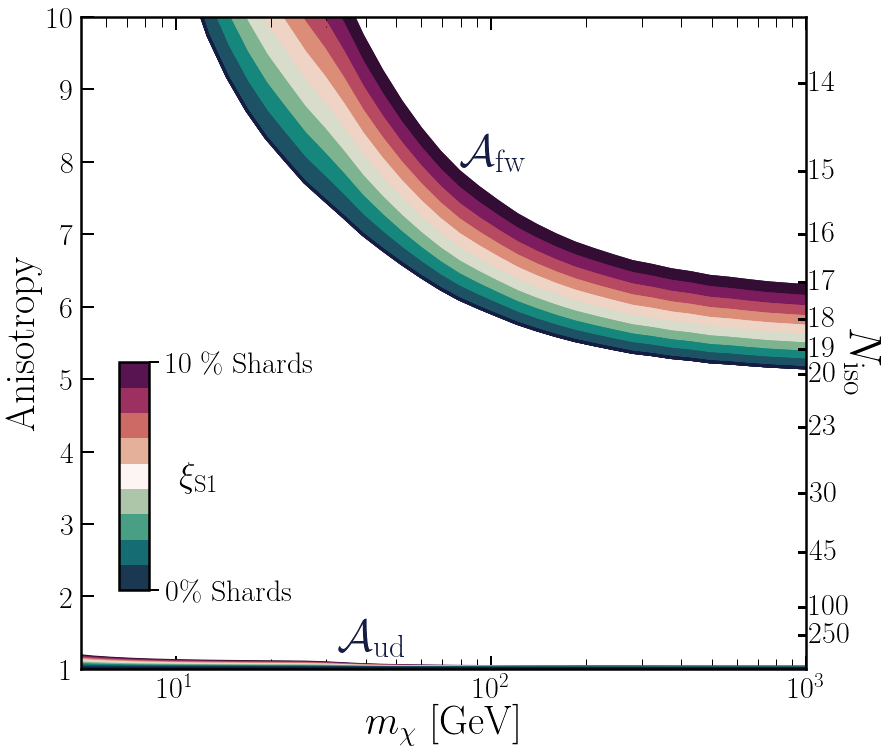

In [142]:
     

fig,ax1 = MySquarePlot('$m_\chi$ [GeV]','Anisotropy',lfs=40,tfs=30)
col = cmocean.cm.curl(linspace(0,1,n_xi))

for i in flipud(range(0,n_xi)):
    plt.fill_between(m_vals,FW[:,i]/BW[:,i],y2=FW[:,0]/BW[:,0],lw=3,color=col[i,:])
    plt.fill_between(m_vals,DN[:,i]/UP[:,i],y2=DN[:,0]/UP[:,0],lw=3,color=col[i,:])
    #plt.plot(m_vals,FW[:,i]/BW[:,i],'-',lw=5,color='k')
    #plt.plot(m_vals,DN[:,i]/UP[:,i],'-',lw=5,color='k')
    plt.plot(m_vals,FW[:,i]/BW[:,i],'-',lw=3,color=col[i,:])
    plt.plot(m_vals,DN[:,i]/UP[:,i],'-',lw=3,color=col[i,:])
    
    

plt.gcf().text(0.53,0.7,r'$\mathcal{A}_{\rm fw}$',fontsize=45,color=col[0,:])
plt.gcf().text(0.4,0.14,r'$\mathcal{A}_{\rm ud}$',fontsize=45,color=col[0,:])

ymin = 1.0
ymax = 10.0
xmin = 5.0
xmax = 1000.0

#ivals = array(11,)

Nvals = array([14,15,16,17,18,19,20,23,30,45,100,250])
for i in Nvals:
    A = (sqrt(i*1)/3.0 + 1)/(sqrt(i*1)/3.0 - 1)
    #plt.plot([xmin,xmax],[A,A],'--',lw=2,color='gray')
    plt.plot([xmax*0.95,xmax],[A,A],'-',lw=3,color='k')
    plt.text(xmax+20,A,str(i),fontsize=30,va='center')

plt.ylim([ymin,ymax])
plt.xscale('log')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])


#ax2 = ax1.twinx()
#ax2.set_yscale('log')
#ax2.set_ylim([Niso(ymin),Niso(ymax)])
#ax2.set_yticks(arange(Niso(ymin),Niso(ymax),1))

#ax1.xaxis.grid() # vertical lines
#ax1.xaxis.grid(which='minor') # vertical lines

ax1.tick_params(which='major',right=False)
ax1.tick_params(which='minor',right=False)


plt.gcf().text(0.93,0.45,r'$N_{\rm iso}$',fontsize=45,rotation=-90)


# Custom colorbar
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax1, width="15%", height="30%", bbox_to_anchor=[0, -330, 200, 760]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmocean.cm.curl, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi),orientation='vertical')
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min,cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.23,0.33,r'$\xi_{\rm S1}$',fontsize=35,color='k')


plt.show()
pltname = 'Anisotropy_S1'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')